In [31]:
import os
import sys
import numpy as np
import keras.callbacks as cb
import keras.utils.np_utils as np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GaussianNoise
from keras.layers.core import Activation
from keras.constraints import maxnorm
from keras import applications # For easy loading the VGG_16 Model
from skimage import color
import sklearn.metrics as skm
import cv2
# Image loading and other helper functions
import dwdii_bc_model_helper as bc
from matplotlib import pyplot as plt

## Image_Augmentation
The following function takes the 8bit grayscale images that we are using and performs a series of affine transformations to the images. There are vertical and horizontal flips along with rotations of 90, 270, 15, 30, and 45 degrees. Also included is a function for generating the rotations. Image augmentation needs to be performed before runnin the VGG_Prep function.  

When calling the Image_Augmentation function setting the various flags to True will cause the transformation to be performed.

In [3]:
# Function for rotating the image files.
def Image_Rotate(img, angle):
    """
    Rotates a given image the requested angle. Returns the rotated image.
    """
    rows,cols = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    return(cv2.warpAffine(img,M,(cols,rows)))

# Function for augmenting the images
def Image_Augment(X, Y, vflip=False, hflip=False, major_rotate=False, minor_rotate=False):
    """
    :param  X np.array of images
            Y np.array of labels
            vflip, hflip, major_rotate, minor_rotate set to True to perform the augmentations
    :return The set of augmented iages and their corresponding labels
    
    """
    if len(X) != len(Y):
        print('Data and Label arrays not of the same length.')
    
    n = vflip + hflip + 2*major_rotate + 6*minor_rotate
    augmented = np.zeros([len(X) + n*len(X), X.shape[1], X.shape[2]])
    label = np.zeros([len(Y) + n*len(Y), 1])
    count = 0
    for i in range(0, len(X)):
        augmented[count] = X[i]
        label[count] = Y[i]
        count += 1
        if vflip:
            aug = cv2.flip(X[i], 0)
            augmented[count] = aug
            label[count] = Y[i]
            count += 1
        if hflip:
            aug = cv2.flip(X[i], 1)
            augmented[count] = aug
            label[count] = Y[i]
            count +=1 
        if major_rotate:
            angles = [90, 270]
            for angle in angles:
                aug = Image_Rotate(X[i], angle)
                augmented[count] = aug
                label[count] = Y[i]
                count += 1
        if minor_rotate:
            angles = [-45,-30,-15,15,30,45]
            for angle in angles:
                aug = Image_Rotate(X[i], angle)
                augmented[count] = aug
                label[count] = Y[i]
                count += 1
                
    return(augmented, label)

### VGG_Prep
The following function takes the 8bit grayscale images that we are using and converts them to 8bit rgb while at the same time changing the pixles to a scale of 0 to 255. These image parameters are required by the VGG_16 model. 

In [4]:
def VGG_Prep(img_data):
    """
    :param img_data: training or test images of shape [#images, height, width]
    :return: the array transformed to the correct shape for the VGG network
                shape = [#images, height, width, 3] transforms to rgb and reshapes
    """
    images = np.zeros([len(img_data), img_data.shape[1], img_data.shape[2], 3])
    for i in range(0, len(img_data)):
        im = 255 - (img_data[i] * 255)  # Orginal imagnet images were not rescaled
        im = color.gray2rgb(im)
        images[i] = im
    return(images)

### VGG_16 Bottleneck
The following function leverages Daniel's image loader function and performs the following:
1. Loads in the images using the train, test, and validation csv files.
2. Prepares the images using the VGG_Prep function
3. Loads the VGG_16 model with the cassification layers removed.
4. Runs each of the images for the training, test, and validation sets (if included) through the model.
5. Saves out .npy files containing the bottleneck features from the VGG_16 model predictions and the corresponding labels.

In [5]:
def vgg16_bottleneck(trainPath, testPath, imagePath, modelPath, size, balance = True, verbose = True, 
                     verboseFreq = 50, valPath = 'None', transform = False, binary = False):
    
    categories = bc.bcNormVsAbnormNumerics()
    
    # Loading data
    metaTr, metaTr2, mCountsTr = bc.load_training_metadata(trainPath, balance, verbose)
    lenTrain = len(metaTr)
    X_train, Y_train = bc.load_data(trainPath, imagePath, maxData = lenTrain,
                                    categories=categories,
                                    verboseFreq = verboseFreq, 
                                    imgResize=size, 
                                    normalVsAbnormal=binary)
    
    metaTest, meataT2, mCountsT = bc.load_training_metadata(testPath, balance, verbose)
    lenTest = len(metaTest)
    X_test, Y_test = bc.load_data(testPath, imagePath, maxData = lenTrain, 
                                  categories=categories,
                                  verboseFreq = verboseFreq, 
                                  imgResize=size, 
                                  normalVsAbnormal=binary)
    
    if transform:
        print('Transforming the Training Data')
        X_train, Y_train = Image_Augment(X=X_train, Y=Y_train, hflip=True, vflip=True, minor_rotate=False, major_rotate=False)
    
    print('Preparing the Training Data for the VGG_16 Model.')
    X_train = VGG_Prep(X_train)
    print('Preparing the Test Data for the VGG_16 Model')
    X_test = VGG_Prep(X_test)
        
    print('Loading the VGG_16 Model')
    model = applications.VGG16(include_top=False, weights='imagenet')
        
    # Generating the bottleneck features for the training data
    print('Evaluating the VGG_16 Model on the Training Data')
    bottleneck_features_train = model.predict(X_train)
    
    # Saving the bottleneck features for the training data
    featuresTrain = os.path.join(modelPath, 'bottleneck_features_train.npy')
    labelsTrain = os.path.join(modelPath, 'labels_train.npy')
    print('Saving the Training Data Bottleneck Features.')
    np.save(open(featuresTrain, 'wb'), bottleneck_features_train)
    np.save(open(labelsTrain, 'wb'), Y_train)

    # Generating the bottleneck features for the test data
    print('Evaluating the VGG_16 Model on the Test Data')
    bottleneck_features_test = model.predict(X_test)
    
    # Saving the bottleneck features for the test data
    featuresTest = os.path.join(modelPath, 'bottleneck_features_test.npy')
    labelsTest = os.path.join(modelPath, 'labels_test.npy')
    print('Saving the Test Data Bottleneck Feaures.')
    np.save(open(featuresTest, 'wb'), bottleneck_features_test)
    np.save(open(labelsTest, 'wb'), Y_test)
    
    if valPath != 'None':
        metaVal, metaV2, mCountsV = bc.load_training_metadata(valPath, verbose = verbose, balanceViaRemoval = False)
        lenVal = len(metaVal)
        X_val, Y_val = bc.load_data(valPath, imagePath, maxData = lenVal, verboseFreq = verboseFreq, imgResize=size)
        X_val = VGG_Prep(X_val)
        
        # Generating the bottleneck features for the test data
        print('Evaluating the VGG_16 Model on the Validataion Data')
        bottleneck_features_val = model.predict(X_val)
    
        # Saving the bottleneck features for the test data
        featuresVal = os.path.join(modelPath, 'bottleneck_features_validation.npy')
        labelsVal = os.path.join(modelPath, 'labels_validation.npy')
        print('Saving the Validation Data Bottleneck Features.')
        np.save(open(featuresVal, 'wb'), bottleneck_features_val)
        np.save(open(labelsVal, 'wb'), Y_val)

## Running the model on the Train, Test, and Validation Data
1) The first test is on the rescaled and squared off images maintaining aspect ratio without the artifacts removed.

In [31]:
# global variables for loading the data
imagePath = '../images/threshold/DDSM/'
trainDataPath = '../images/ddsm/ddsm_train.csv'
testDataPath = '../images/ddsm/ddsm_test.csv'
valDataPath = '../images/ddsm/ddsm_val.csv'
imgResize = (224, 224) # can go up to (224, 224)
modelPath = '../model/'

In [32]:
vgg16_bottleneck(trainDataPath, testDataPath, imagePath, modelPath, imgResize, 
                 balance = True, verbose = True, verboseFreq = 50, valPath = valDataPath, 
                 transform = False, binary = True)

Raw Balance
----------------
benign 531
malignant 739
normal 2685
balanaceViaRemoval.avgE: 1318
balanaceViaRemoval.theshold: 1318.0

After Balancing
----------------
benign 531
malignant 739
normal 862
Raw Balance
----------------
abnormal 1270
normal 2685
balanaceViaRemoval.avgE: 1977
balanaceViaRemoval.theshold: 1977.0

After Balancing
----------------
abnormal 1270
normal 1623
0.0000: A_0152_1.RIGHT_MLO.LJPEG.png
Not Found: ../images/threshold/DDSM/1\A_1033_1.LEFT_CC.LJPEG.png
Not Found: ../images/threshold/DDSM/0\A_0619_1.RIGHT_MLO.LJPEG.png
Not Found: ../images/threshold/DDSM/1\A_1087_1.RIGHT_CC.LJPEG.png
Not Found: ../images/threshold/DDSM/0\A_0022_1.RIGHT_MLO.LJPEG.png
0.0235: A_1077_1.RIGHT_MLO.LJPEG.png
Not Found: ../images/threshold/DDSM/0\A_0491_1.RIGHT_CC.LJPEG.png
Not Found: ../images/threshold/DDSM/0\A_0124_1.RIGHT_CC.LJPEG.png
Not Found: ../images/threshold/DDSM/1\A_1010_1.RIGHT_CC.LJPEG.png
0.0469: C_0130_1.LEFT_CC.LJPEG.png
Not Found: ../images/threshold/DDSM/1\A_1065_

In [6]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

## Train Top Model
This function takes the bottleneck features from the bottleneck function and applies a shallow CNN to these features to classify the images. The function needs to be pointed at the locations of the training and test features along with the training and test labels. You can use the epoch and batch size variables to control the number of images to show to the model and the number of training epochs. The model save variabler alows for saving of the final model weights.

In [36]:
def train_top_model(train_feats, train_lab, test_feats, test_lab, model_path, model_save, epoch = 50, batch = 64):
    train_bottleneck = os.path.join(model_path, train_feats)
    train_labels = os.path.join(model_path, train_lab)
    test_bottleneck = os.path.join(model_path, test_feats)
    test_labels = os.path.join(model_path, test_lab)
    
    history = LossHistory()
    
    X_train = np.load(train_bottleneck)
    Y_train = np.load(train_labels)
    #Y_train = np_utils.to_categorical(Y_train, nb_classes=3)
    Y_train = np_utils.to_categorical(Y_train, nb_classes=2)
    
    X_test = np.load(test_bottleneck)
    Y_test = np.load(test_labels)
    #Y_test = np_utils.to_categorical(Y_test, nb_classes=3)
    Y_test = np_utils.to_categorical(Y_test, nb_classes=2)
    print(X_train.shape)
    
    noise = 0.01
    
    model = Sequential()
    model.add( GaussianNoise(noise, input_shape=X_train.shape[1:]))
    model.add(Flatten(input_shape=X_train.shape[1:]))
    model.add(Dropout(0.7))
    model.add( Dense(256, activation = 'relu') )
    model.add(Dropout(0.5))
    #model.add(Dense(3))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    #loss = 'categorical_crossentropy'
    model.compile(optimizer='adadelta',
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    model.fit(X_train, Y_train,
              nb_epoch=epoch,
              batch_size=batch,
              callbacks=[history],
              validation_data=(X_test, Y_test),
              verbose=2)
    
    score = model.evaluate(X_test, Y_test, batch_size=16, verbose=0)

    print "Network's test score [loss, accuracy]: {0}".format(score)
    
    model.save_weights(os.path.join(model_path, model_save))

## Confusion Matrix
The function below takes a data set that has been run through the VGG16 model, the corresponding labels, and a pre-trained weights file and creates a confusion matrix using Daniel's helper function.

In [22]:
def cf_Matrix(data, label, weights, path, save):
    data = os.path.join(path, data)
    label = os.path.join(path, label)
    categories = bc.bcNormVsAbnormNumerics()
    
    X = np.load(data)
    Y = np.load(label)
    #Y = np_utils.to_categorical(Y, nb_classes=3)
    
    # Loading and preping the model
    model = Sequential()
    model.add(Flatten(input_shape=X.shape[1:]))
    model.add(Dropout(0.7))
    
    model.add(Dense(256))
    model.add(Activation('relu'), constraint= maxnorm(3.))
    model.add(Dropout(0.5))
    
    #model.add(Dense(3))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    model.load_weights(os.path.join('../model/', weights))
    
    # try Adadelta and Adam
    model.compile(optimizer='adadelta',
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    predictOutput = model.predict(X, batch_size=64, verbose=2)
    #numBC = bc.numericBC()
    numBC = bc.reverseDict(categories)
    
    predClasses = []
    for i in range(len(predictOutput)):
        arPred = np.array(predictOutput[i])
        predictionProb = arPred.max()
        predictionNdx = arPred.argmax()
        predClassName = numBC[predictionNdx]
        predClasses.append(predictionNdx)
        
    # Use sklearn's helper method to generate the confusion matrix
    cnf_matrix = skm.confusion_matrix(Y, predClasses)
    
    # Ploting the confusion matrix
    class_names = numBC.values()
    np.set_printoptions(precision=2)
    
    fileCfMatrix = '../figures/confusion_matrix-' + save + '.png'
    plt.figure()
    bc.plot_confusion_matrix(cnf_matrix, classes=class_names,
                             title='Confusion matrix, \n' + save)
    plt.savefig(fileCfMatrix)
    plt.show()

## Running the Top Model
The following runs the top model classifier on the bottleneck features.

In [6]:
# Locations for the bottleneck and labels files that we need
modelPath = '../model/'
train_bottleneck = 'bottleneck_features_train.npy'
train_labels = 'labels_train.npy'
test_bottleneck = 'bottleneck_features_test.npy'
test_labels = 'labels_test.npy'
validation_bottleneck = 'bottleneck_features_valdation.npy'
validation_label = 'labels_validation.npy'
top_model_weights_path = 'top_weights02.h5'

In [10]:
train_top_model(train_feats=train_bottleneck, train_lab=train_labels, test_feats=test_bottleneck, test_lab=test_labels,
                model_path=modelPath, model_save=top_model_weights_path)

Train on 2132 samples, validate on 536 samples
Epoch 1/50
0s - loss: 6.5851 - acc: 0.4508 - val_loss: 5.6644 - val_acc: 0.4571
Epoch 2/50
0s - loss: 3.4335 - acc: 0.5563 - val_loss: 2.2755 - val_acc: 0.5000
Epoch 3/50
0s - loss: 1.0971 - acc: 0.6393 - val_loss: 1.2428 - val_acc: 0.5243
Epoch 4/50
0s - loss: 0.6560 - acc: 0.7317 - val_loss: 1.3331 - val_acc: 0.4963
Epoch 5/50
0s - loss: 0.5417 - acc: 0.7767 - val_loss: 1.3829 - val_acc: 0.5019
Epoch 6/50
0s - loss: 0.4130 - acc: 0.8354 - val_loss: 1.4304 - val_acc: 0.5392
Epoch 7/50
0s - loss: 0.3163 - acc: 0.8752 - val_loss: 1.5420 - val_acc: 0.5187
Epoch 8/50
0s - loss: 0.2728 - acc: 0.8963 - val_loss: 1.5069 - val_acc: 0.5168
Epoch 9/50
0s - loss: 0.2050 - acc: 0.9282 - val_loss: 1.6816 - val_acc: 0.5243
Epoch 10/50
0s - loss: 0.1788 - acc: 0.9273 - val_loss: 1.6940 - val_acc: 0.5485
Epoch 11/50
0s - loss: 0.1626 - acc: 0.9465 - val_loss: 1.7204 - val_acc: 0.5299
Epoch 12/50
0s - loss: 0.1236 - acc: 0.9578 - val_loss: 1.7611 - val_ac

In [37]:
feats_loc = '150_test_val/bottleneck_features_test.npy'
feats_labs = '150_test_val/labels_test.npy'
weight = 'balanced150run2/top_weights02.h5'
saveFile = 'balanced150'

Confusion matrix, without normalization
[[136  34  45]
 [ 25  91  26]
 [ 45  37  97]]


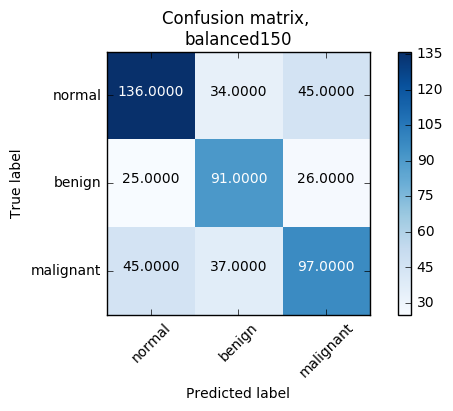

In [38]:
cf_Matrix(data=feats_loc, label=feats_labs, weights=weight, path=modelPath, save=saveFile)

## Running the Top Model on the Fully Augmented Data
In this run we will be using the bottleneck features from taking the training data and augmenting it with the followin transformations; Vertical Flip, Horizontal Flip, 90 and 270 degree rotation, and 15, 30, and 45 degree rotation in both directions.

In [16]:
# Locations for the bottleneck and labels files that we need
modelPath = '../model/'
train_bottleneck = 'bottleneck_features_150fulltrans_train.npy'
train_labels = 'labels_150fulltrans_train.npy'
test_bottleneck = 'bottleneck_features_test.npy'
test_labels = 'labels_test.npy'
validation_bottleneck = 'bottleneck_features_valdation.npy'
validation_label = 'labels_validation.npy'
top_model_weights_path = 'top_weights_150fulltrans.h5'

In [17]:
train_top_model(train_feats=train_bottleneck, train_lab=train_labels, test_feats=test_bottleneck, test_lab=test_labels,
                model_path=modelPath, model_save=top_model_weights_path)

Train on 23452 samples, validate on 536 samples
Epoch 1/50
9s - loss: 2.1150 - acc: 0.5010 - val_loss: 0.9707 - val_acc: 0.5429
Epoch 2/50
9s - loss: 0.8477 - acc: 0.6011 - val_loss: 1.0201 - val_acc: 0.5690
Epoch 3/50
9s - loss: 0.7545 - acc: 0.6495 - val_loss: 1.0338 - val_acc: 0.5709
Epoch 4/50
10s - loss: 0.6726 - acc: 0.6937 - val_loss: 1.1553 - val_acc: 0.5634
Epoch 5/50
12s - loss: 0.6003 - acc: 0.7329 - val_loss: 1.1349 - val_acc: 0.5709
Epoch 6/50
13s - loss: 0.5381 - acc: 0.7633 - val_loss: 1.2890 - val_acc: 0.5784
Epoch 7/50
13s - loss: 0.4795 - acc: 0.7914 - val_loss: 1.3350 - val_acc: 0.5728
Epoch 8/50
13s - loss: 0.4376 - acc: 0.8142 - val_loss: 1.3227 - val_acc: 0.5877
Epoch 9/50
12s - loss: 0.3839 - acc: 0.8383 - val_loss: 1.4640 - val_acc: 0.5560
Epoch 10/50
12s - loss: 0.3497 - acc: 0.8528 - val_loss: 1.5536 - val_acc: 0.5765
Epoch 11/50
12s - loss: 0.3168 - acc: 0.8711 - val_loss: 1.6186 - val_acc: 0.5784
Epoch 12/50
12s - loss: 0.2859 - acc: 0.8848 - val_loss: 1.624

In [35]:
feats_loc = '150_test_val/bottleneck_features_test.npy'
feats_labs = '150_test_val/labels_test.npy'
weight = 'balanced150FullTrans/top_weights_150fulltrans.h5'
saveFile = 'balanced150FullTrans'

Confusion matrix, without normalization
[[141  28  46]
 [ 26  76  40]
 [ 57  32  90]]


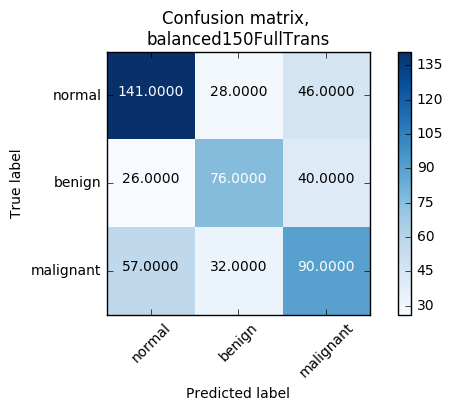

In [36]:
cf_Matrix(data=feats_loc, label=feats_labs, weights=weight, path=modelPath, save=saveFile)

## Running the Top Model at 224x224
In this next experiment we run the model with transformations on the data at a size of 224x224

In [22]:
# Locations for the bottleneck and labels files that we need
modelPath = '../model/'
train_bottleneck = 'bottleneck_features_train_224.npy'
train_labels = 'labels_train_224.npy'
test_bottleneck = 'bottleneck_features_test.npy'
test_labels = 'labels_test.npy'
validation_bottleneck = 'bottleneck_features_valdation.npy'
validation_label = 'labels_validation.npy'
top_model_weights_path = 'top_weights_224.h5'

In [23]:
train_top_model(train_feats=train_bottleneck, train_lab=train_labels, test_feats=test_bottleneck, test_lab=test_labels,
                model_path=modelPath, model_save=top_model_weights_path)

Train on 2132 samples, validate on 536 samples
Epoch 1/50
2s - loss: 9.0933 - acc: 0.4170 - val_loss: 8.1122 - val_acc: 0.4608
Epoch 2/50
2s - loss: 8.1198 - acc: 0.4634 - val_loss: 9.5227 - val_acc: 0.4030
Epoch 3/50
2s - loss: 7.4928 - acc: 0.5033 - val_loss: 7.4591 - val_acc: 0.4776
Epoch 4/50
2s - loss: 6.3570 - acc: 0.5432 - val_loss: 6.4214 - val_acc: 0.5466
Epoch 5/50
2s - loss: 5.6562 - acc: 0.5943 - val_loss: 5.6958 - val_acc: 0.5634
Epoch 6/50
2s - loss: 4.9501 - acc: 0.6196 - val_loss: 6.8575 - val_acc: 0.5168
Epoch 7/50
2s - loss: 4.3462 - acc: 0.6384 - val_loss: 7.0712 - val_acc: 0.4571
Epoch 8/50
2s - loss: 2.2618 - acc: 0.6731 - val_loss: 1.3050 - val_acc: 0.5914
Epoch 9/50
2s - loss: 0.7706 - acc: 0.7233 - val_loss: 1.1151 - val_acc: 0.5765
Epoch 10/50
2s - loss: 0.5902 - acc: 0.7617 - val_loss: 1.1186 - val_acc: 0.6101
Epoch 11/50
2s - loss: 0.4783 - acc: 0.8096 - val_loss: 1.2259 - val_acc: 0.6194
Epoch 12/50
2s - loss: 0.3681 - acc: 0.8462 - val_loss: 1.3938 - val_ac

### Generating the Confusion Matrix for the Balanced 224x224 Run

In [25]:
feats_loc = '224_test_val/bottleneck_features_test.npy'
feats_labs = '224_test_val/labels_test.npy'
weight = 'balanced224/top_weights_224.h5'
saveFile = 'balanced224'

Confusion matrix, without normalization
[[142  27  46]
 [ 33  84  25]
 [ 60  24  95]]


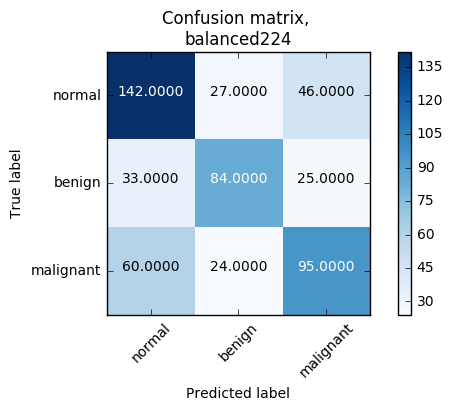

In [34]:
cf_Matrix(data=feats_loc, label=feats_labs, weights=weight, path=modelPath, save=saveFile)

## 224x224 With Flips

In [5]:
# Locations for the bottleneck and labels files that we need
modelPath = '../model/'
train_bottleneck = 'Balanced224flips/bottleneck_features_train_224flip.npy'
train_labels = 'Balanced224flips/labels_train_224flip.npy'
test_bottleneck = '224_test_val/bottleneck_features_test.npy'
test_labels = '224_test_val/labels_test.npy'
validation_bottleneck = 'bottleneck_features_valdation.npy'
validation_label = 'labels_validation.npy'
top_model_weights_path = 'Balanced224flips/top_weights_224flip.h5'

In [10]:
train_top_model(train_feats=train_bottleneck, train_lab=train_labels, test_feats=test_bottleneck, test_lab=test_labels,
                model_path=modelPath, model_save=top_model_weights_path)

Train on 6396 samples, validate on 536 samples
Epoch 1/50
9s - loss: 5.5444 - acc: 0.4927 - val_loss: 1.2293 - val_acc: 0.5336
Epoch 2/50
9s - loss: 0.9085 - acc: 0.5758 - val_loss: 1.0227 - val_acc: 0.5765
Epoch 3/50
9s - loss: 0.8059 - acc: 0.6254 - val_loss: 1.0468 - val_acc: 0.5877
Epoch 4/50
9s - loss: 0.7276 - acc: 0.6645 - val_loss: 1.1345 - val_acc: 0.5765
Epoch 5/50
9s - loss: 0.6415 - acc: 0.7065 - val_loss: 1.1480 - val_acc: 0.5821
Epoch 6/50
9s - loss: 0.5666 - acc: 0.7461 - val_loss: 1.2448 - val_acc: 0.5933
Epoch 7/50
9s - loss: 0.5022 - acc: 0.7824 - val_loss: 1.3077 - val_acc: 0.5821
Epoch 8/50
9s - loss: 0.4410 - acc: 0.8114 - val_loss: 1.4826 - val_acc: 0.6063
Epoch 9/50
9s - loss: 0.3718 - acc: 0.8438 - val_loss: 1.5838 - val_acc: 0.5951
Epoch 10/50
9s - loss: 0.3322 - acc: 0.8604 - val_loss: 1.4636 - val_acc: 0.6231
Epoch 11/50
10s - loss: 0.2835 - acc: 0.8816 - val_loss: 1.5400 - val_acc: 0.6306
Epoch 12/50
10s - loss: 0.2514 - acc: 0.8960 - val_loss: 1.8208 - val_

In [11]:
feats_loc = '224_test_val/bottleneck_features_test.npy'
feats_labs = '224_test_val/labels_test.npy'
weight = 'balanced224flips/top_weights_224flip.h5'
saveFile = 'balanced224flip'

Confusion matrix, without normalization
[[143  18  54]
 [ 24  86  32]
 [ 56  22 101]]


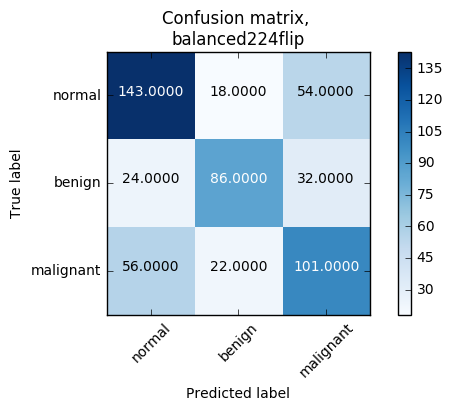

In [16]:
cf_Matrix(data=feats_loc, label=feats_labs, weights=weight, path=modelPath, save=saveFile)

## Thresholded Images at 224x224 with no Augmentations

In [77]:
# Locations for the bottleneck and labels files that we need
modelPath = '../model/'
train_bottleneck = 'bottleneck_features_train_224th.npy'
train_labels = 'labels_train_224th.npy'
test_bottleneck = 'bottleneck_features_test.npy'
test_labels = 'labels_test.npy'
validation_bottleneck = 'bottleneck_features_valdation.npy'
validation_label = 'labels_validation.npy'
top_model_weights_path = 'top_weights_224th.h5'

In [78]:
train_top_model(train_feats=train_bottleneck, train_lab=train_labels, test_feats=test_bottleneck, test_lab=test_labels,
                model_path=modelPath, model_save=top_model_weights_path)

Train on 2014 samples, validate on 510 samples
Epoch 1/50
3s - loss: 8.1830 - acc: 0.4464 - val_loss: 8.2889 - val_acc: 0.4529
Epoch 2/50
3s - loss: 7.1938 - acc: 0.5238 - val_loss: 8.9006 - val_acc: 0.4196
Epoch 3/50
3s - loss: 6.8866 - acc: 0.5328 - val_loss: 7.2767 - val_acc: 0.4980
Epoch 4/50
3s - loss: 5.9568 - acc: 0.5814 - val_loss: 7.6397 - val_acc: 0.4843
Epoch 5/50
3s - loss: 5.8106 - acc: 0.5983 - val_loss: 6.7615 - val_acc: 0.5294
Epoch 6/50
3s - loss: 5.3491 - acc: 0.6112 - val_loss: 7.0674 - val_acc: 0.5098
Epoch 7/50
3s - loss: 4.5578 - acc: 0.6594 - val_loss: 7.1049 - val_acc: 0.4922
Epoch 8/50
3s - loss: 4.3890 - acc: 0.6430 - val_loss: 5.2989 - val_acc: 0.5275
Epoch 9/50
3s - loss: 2.9174 - acc: 0.7046 - val_loss: 3.4844 - val_acc: 0.5569
Epoch 10/50
3s - loss: 1.2611 - acc: 0.7393 - val_loss: 1.4448 - val_acc: 0.5196
Epoch 11/50
3s - loss: 0.5694 - acc: 0.8059 - val_loss: 1.4692 - val_acc: 0.5412
Epoch 12/50
3s - loss: 0.4477 - acc: 0.8322 - val_loss: 1.5084 - val_ac

In [79]:
feats_loc = '224_threshold/bottleneck_features_test.npy'
feats_labs = '224_threshold/labels_test.npy'
weight = 'balanced224Threshold/top_weights_224th.h5'
saveFile = 'balanced224Threshold'

Confusion matrix, without normalization
[[108  39  54]
 [ 15 101  22]
 [ 41  36  94]]


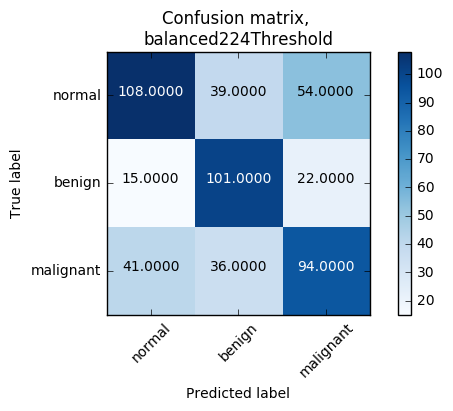

In [80]:
cf_Matrix(data=feats_loc, label=feats_labs, weights=weight, path=modelPath, save=saveFile)

## 224x224 DDSM - Two Categories
Attempting to learn the difference between normal annd abnormal.

In [4]:
# Locations for the bottleneck and labels files that we need
modelPath = '../model/'
train_bottleneck = 'Balanced224Binary/bottleneck_features_train_224twoclass.npy'
train_labels = 'Balanced224Binary/labels_train_224twoclass.npy'
test_bottleneck = '224_binary/bottleneck_features_test.npy'
test_labels = '224_binary/labels_test.npy'
validation_bottleneck = 'bottleneck_features_valdation.npy'
validation_label = 'labels_validation.npy'
top_model_weights_path = 'Balanced224Binary/top_weights_224twoclass.h5'

In [37]:
train_top_model(train_feats=train_bottleneck, train_lab=train_labels, test_feats=test_bottleneck, test_lab=test_labels,
                model_path=modelPath, model_save=top_model_weights_path, epoch = 100)

(2132L, 7L, 7L, 512L)
Train on 2132 samples, validate on 726 samples
Epoch 1/100
10s - loss: 5.7163 - acc: 0.5872 - val_loss: 4.7777 - val_acc: 0.6749
Epoch 2/100
11s - loss: 5.1144 - acc: 0.6435 - val_loss: 4.6995 - val_acc: 0.6240
Epoch 3/100
10s - loss: 4.8718 - acc: 0.6482 - val_loss: 5.3574 - val_acc: 0.6460
Epoch 4/100
10s - loss: 4.8243 - acc: 0.6576 - val_loss: 5.0161 - val_acc: 0.6694
Epoch 5/100
10s - loss: 4.4224 - acc: 0.6689 - val_loss: 4.3386 - val_acc: 0.6515
Epoch 6/100
11s - loss: 4.6102 - acc: 0.6529 - val_loss: 4.3907 - val_acc: 0.6667
Epoch 7/100
11s - loss: 4.1972 - acc: 0.6787 - val_loss: 3.8385 - val_acc: 0.6694
Epoch 8/100
11s - loss: 4.1463 - acc: 0.6764 - val_loss: 4.5849 - val_acc: 0.6694
Epoch 9/100
11s - loss: 3.9566 - acc: 0.6848 - val_loss: 3.4660 - val_acc: 0.6708
Epoch 10/100
11s - loss: 3.4106 - acc: 0.6970 - val_loss: 2.9073 - val_acc: 0.6860
Epoch 11/100
10s - loss: 3.0349 - acc: 0.7036 - val_loss: 1.4431 - val_acc: 0.6584
Epoch 12/100
10s - loss: 2.

In [21]:
feats_loc = '224_binary/bottleneck_features_test.npy'
feats_labs = '224_binary/labels_test.npy'
weight = 'balanced224Binary/top_weights_224twoclass.h5'
saveFile = 'balanced224Twoclass'

Confusion matrix, without normalization
[[294 111]
 [126 195]]


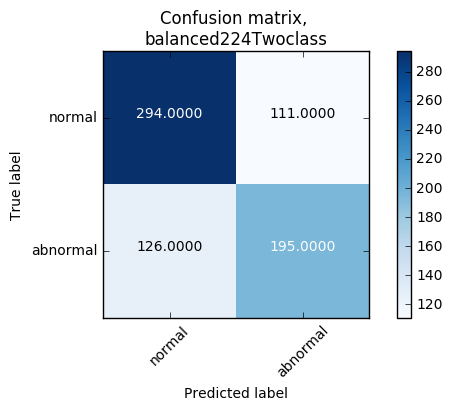

In [22]:
cf_Matrix(data=feats_loc, label=feats_labs, weights=weight, path=modelPath, save=saveFile)

## 224x224 DDSM Thresholded Images - Two Categories

In [33]:
# Locations for the bottleneck and labels files that we need
modelPath = '../model/'
train_bottleneck = 'bottleneck_features_train_224th_twoclass.npy'
train_labels = 'labels_train_224th_twoclass.npy'
test_bottleneck = 'bottleneck_features_test.npy'
test_labels = 'labels_test.npy'
validation_bottleneck = 'bottleneck_features_valdation.npy'
validation_label = 'labels_validation.npy'
top_model_weights_path = 'top_weights_224th_twoclass.h5'

In [35]:
train_top_model(train_feats=train_bottleneck, train_lab=train_labels, test_feats=test_bottleneck, test_lab=test_labels,
                model_path=modelPath, model_save=top_model_weights_path)

Train on 2132 samples, validate on 688 samples
Epoch 1/50
2s - loss: 5.6654 - acc: 0.6055 - val_loss: 5.7420 - val_acc: 0.6134
Epoch 2/50
2s - loss: 4.9361 - acc: 0.6585 - val_loss: 5.2615 - val_acc: 0.6163
Epoch 3/50
2s - loss: 4.8171 - acc: 0.6538 - val_loss: 4.8884 - val_acc: 0.6526
Epoch 4/50
2s - loss: 4.2685 - acc: 0.6895 - val_loss: 4.9389 - val_acc: 0.6308
Epoch 5/50
2s - loss: 3.4425 - acc: 0.7270 - val_loss: 4.1251 - val_acc: 0.6206
Epoch 6/50
2s - loss: 1.9883 - acc: 0.7265 - val_loss: 1.1036 - val_acc: 0.6206
Epoch 7/50
2s - loss: 0.4826 - acc: 0.7871 - val_loss: 0.7872 - val_acc: 0.6076
Epoch 8/50
2s - loss: 0.3752 - acc: 0.8335 - val_loss: 0.8678 - val_acc: 0.6483
Epoch 9/50
2s - loss: 0.3141 - acc: 0.8635 - val_loss: 1.0520 - val_acc: 0.6613
Epoch 10/50
2s - loss: 0.2520 - acc: 0.8912 - val_loss: 1.0241 - val_acc: 0.6483
Epoch 11/50
2s - loss: 0.1943 - acc: 0.9207 - val_loss: 1.1214 - val_acc: 0.6308
Epoch 12/50
2s - loss: 0.1705 - acc: 0.9287 - val_loss: 1.1477 - val_ac

In [40]:
feats_loc = '224_binary/bottleneck_features_test.npy'
feats_labs = '224_binary/labels_test.npy'
weight = 'balanced224Th_Binary/top_weights_224th_twoclass.h5'
saveFile = 'balanced224Th_Twoclass'

Confusion matrix, without normalization
[[334  71]
 [218 103]]


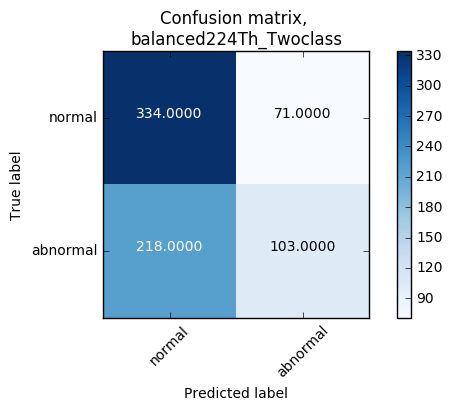

In [41]:
cf_Matrix(data=feats_loc, label=feats_labs, weights=weight, path=modelPath, save=saveFile)

## Results
All results below are run against the train, test, validate csv files located at [Breast Cancer Github Data](https://github.com/jnarhan/Breast_Cancer/tree/master/data)

### Aspect Ratio Squared Raw DDSM Images with Artifacts
1) Run 1: 150x150 image size, 50 Epochs, Batch Size 64
    * Network's test score [loss, accuracy]: [2.4609192387381595, 0.58582089552238803]
2) Run 2: 150x150 image size, 50 Epochs, Batch Size 64, Full Augmentations
    * Network's test score [loss, accuracy]: [2.8447668943832172, 0.57276119402985071]
3) Run 3: 224x224 image size, 50 Epochs, Batch Size 64
    * Network's test score [loss, accuracy]: [2.7020884663311402, 0.59888059701492535]
4) Run 4: 224x224 image size, 50 Epochs, Bath Size 64, Vertical and Horizontal Flips
    * Network's test score [loss, accuracy]: [3.1939952764938129, 0.57276119402985071]

### Aspect Ratio Squard Thresholded DDSM Images
1) Run 1: 224x224 image size, 50 Epochs, Batch Size 64 
    * Network's test score [loss, accuracy]: [3.3308228604933796, 0.59411764752631091]

### Two Class Problem
1) Run 1: 224x224 image size, DDSM images with Artifacts, 50 Epochs, Batch Size = 64 
    * Network's test score [loss, accuracy]: [2.0707934257412743, 0.69834710760221663]
2) Run 2: 224x224 image size, Thresholded images, 50 Epochs, Batch Size = 64
    * Network's test score [loss, accuracy]: [2.465950372607209, 0.65552325581395354]